In [1]:
# Clear memory
%reset -f

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# System imports
import sys
import importlib
from pathlib import Path

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.data',
    'iowa_dream.utils',
    'iowa_dream.feature_engineering',
    'iowa_dream.feature_engineering.add_drop_features',
    'iowa_dream.utils.plotting_EDA',
    'iowa_dream.feature_engineering.categotical_transformer',
    'iowa_dream.feature_engineering.numerical_transformer',
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)

# Project imports
from iowa_dream.data.importer import load_config
from iowa_dream.data.loader import preliminary_loader
from iowa_dream.utils.plotting_EDA import (
    plot_interaction_effects,
    plot_feature_histograms
)

from iowa_dream.feature_engineering.lot_frontage_imputer import *
from iowa_dream.feature_engineering.add_drop_features import *
from iowa_dream.feature_engineering.categotical_transformer import *
from iowa_dream.feature_engineering.numerical_transformer import *

In [3]:
# Example usage
data_file = project_root / load_config()['kaggle']['cleaned_path'] / 'cleaned_AmesHousing.csv'
df = preliminary_loader(data_file)
df.columns

Index(['pid', 'lot_frontage', 'lot_area', 'lot_config', 'neighborhood',
       'overall_qu', 'overall_cond', 'year_blt', 'exterior_1st',
       'mas_vnr_type', 'exter_qu', 'foundation', 'bsmt_qu', 'bsmt_exposure',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating_qu', '2nd_flr_sf',
       'gr_liv_area', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_qu',
       'fireplaces', 'fireplace_qu', 'garage_area', 'wood_deck_sf', 'mo_sold',
       'year_sold', 'saleprice'],
      dtype='object')

In [4]:
# Get data dictionary from config
config = load_config()
cleaned_data_dict = config['cleaned_data_dict']

# Extract feature groups
ordinal_features = cleaned_data_dict['ordinal']['columns']
nominal_features = cleaned_data_dict['nominal']['columns'] 
discrete_features = cleaned_data_dict['discrete']['columns']
continuous_features = cleaned_data_dict['continuous']['columns']
proximity_data = {
    neighborhood: group['category'] 
    for group in config['university_proximity']
    for neighborhood in group['neighborhoods']
}

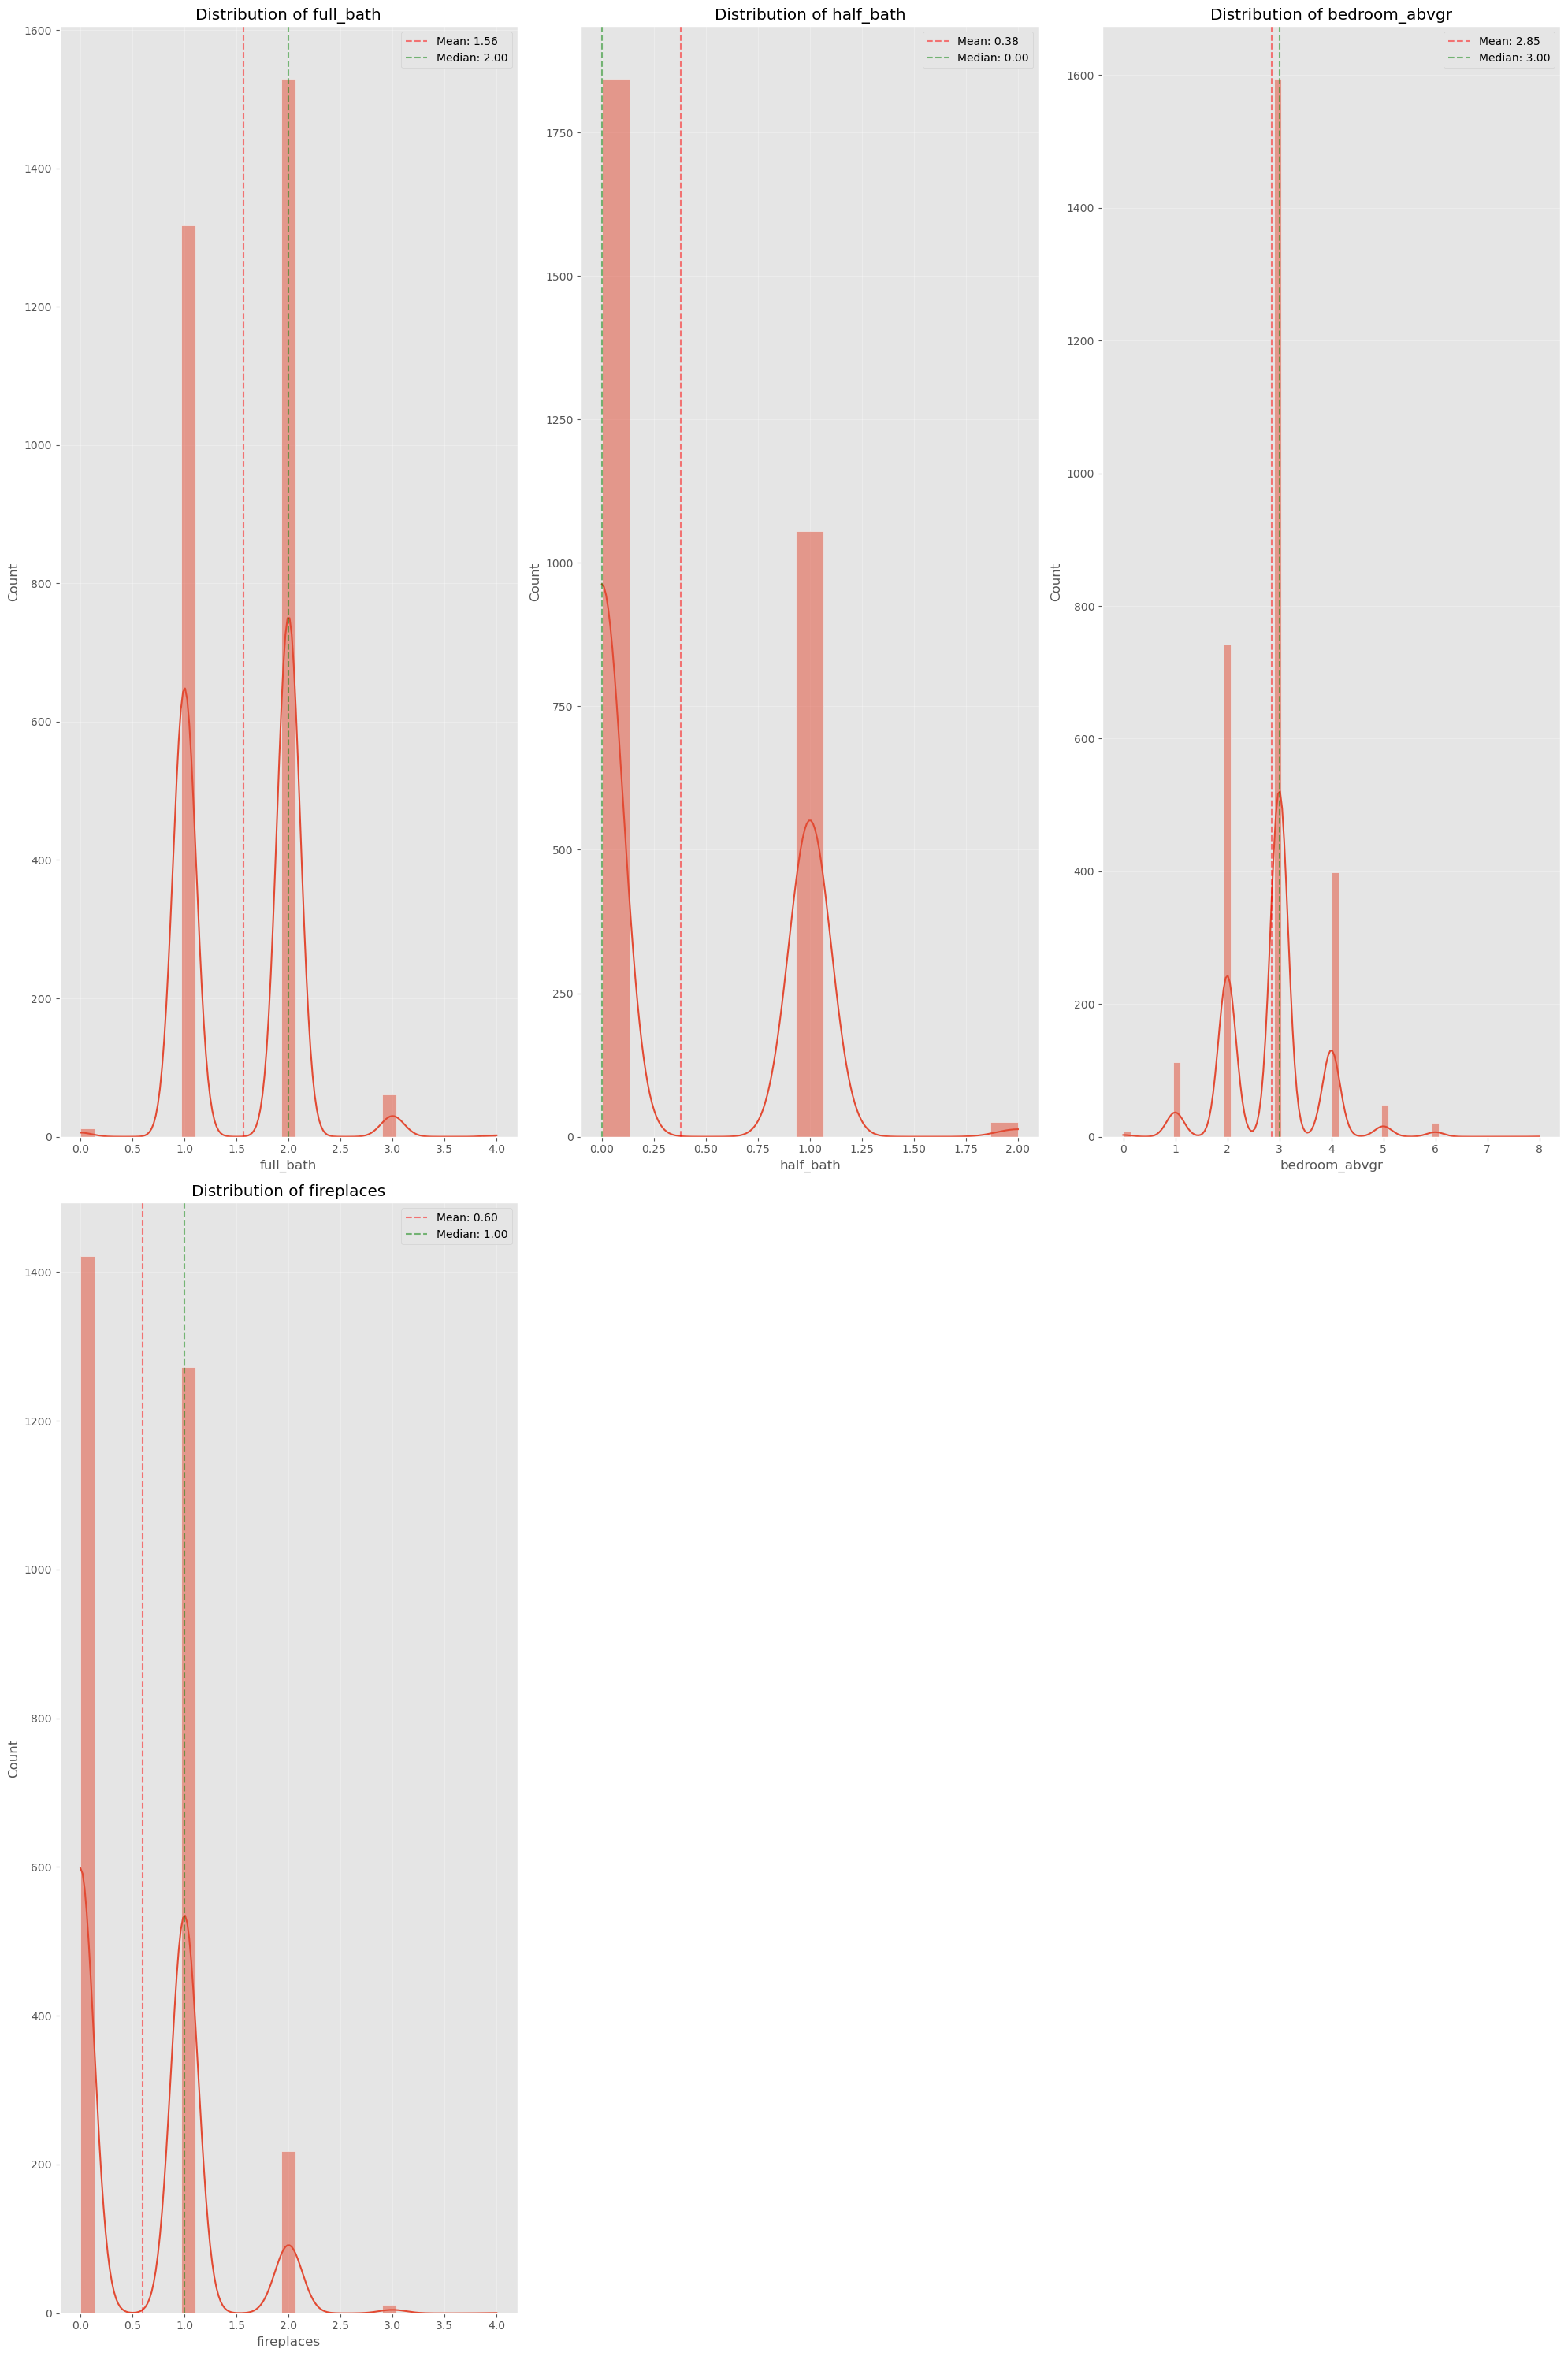

In [5]:
plot_feature_histograms(df, discrete_features)

# 0. Add new (combined) features 

1. **`total_bath`**: Combines full and half bathrooms to capture the overall availability of bathrooms, a key factor influencing property value given that the distibution of half bathrooms is skewed towards the lower end.

2. **`university_proximity_category`**: Categorizes neighborhoods by proximity to universities, as properties closer to universities often have lower values in Iowa due to concerns about disruptions from university activities and richer people tend not to live close to universities.

3. **`neighborhood_score`**: Calculates the median of overall quality + condition scores for each neighborhood, providing a representative measure of neighborhood quality based on the typical property condition in that area.

4. **`overall_score`**: Sums overall quality and condition, directly indicating the general appeal and structural integrity of the house.

5. **`interior_qu`**: Aggregates interior feature qualities (e.g., kitchen, heating, basement) to represent the overall interior quality, which heavily impacts buyer perception.

6. **`season_indicator`**: Encodes the season of sale, as housing demand and prices often fluctuate seasonally.

7. **`age`**: Captures the age of the house since construction, which is a proxy for potential maintenance needs and desirability.

8. **`has_vnr`**: Flags whether the house has a masonry veneer, often associated with higher-quality exteriors and better aesthetics, to deal with too large number of houses with no masonry veneer in the dataset.

9. **`has_2nd_floor`**: Indicates the presence of a second floor, which generally contributes to greater living space and higher property value to deal with too large number of houses with no second floor in the dataset.

10. **`has_wood_deck`**: Identifies houses with a wood deck, a desirable outdoor feature that enhances livability and appeal, to deal with too large number of houses with no wood deck in the dataset.

11. **`pct_unf_sf`**: Measures the proportion of unfinished basement space, which can indicate the potential for additional living space or development to better capture information about the level of finished basement space, partially capturing its quality, without explicitly including another ones to avoid multicollinearity.

In [6]:
# Transform data with new features
add_drop = Add_Drop_Attributes(proximity_data=proximity_data, drop_original=True)
df_transformed = add_drop.fit_transform(df.drop(['pid', 'saleprice'], axis=1))

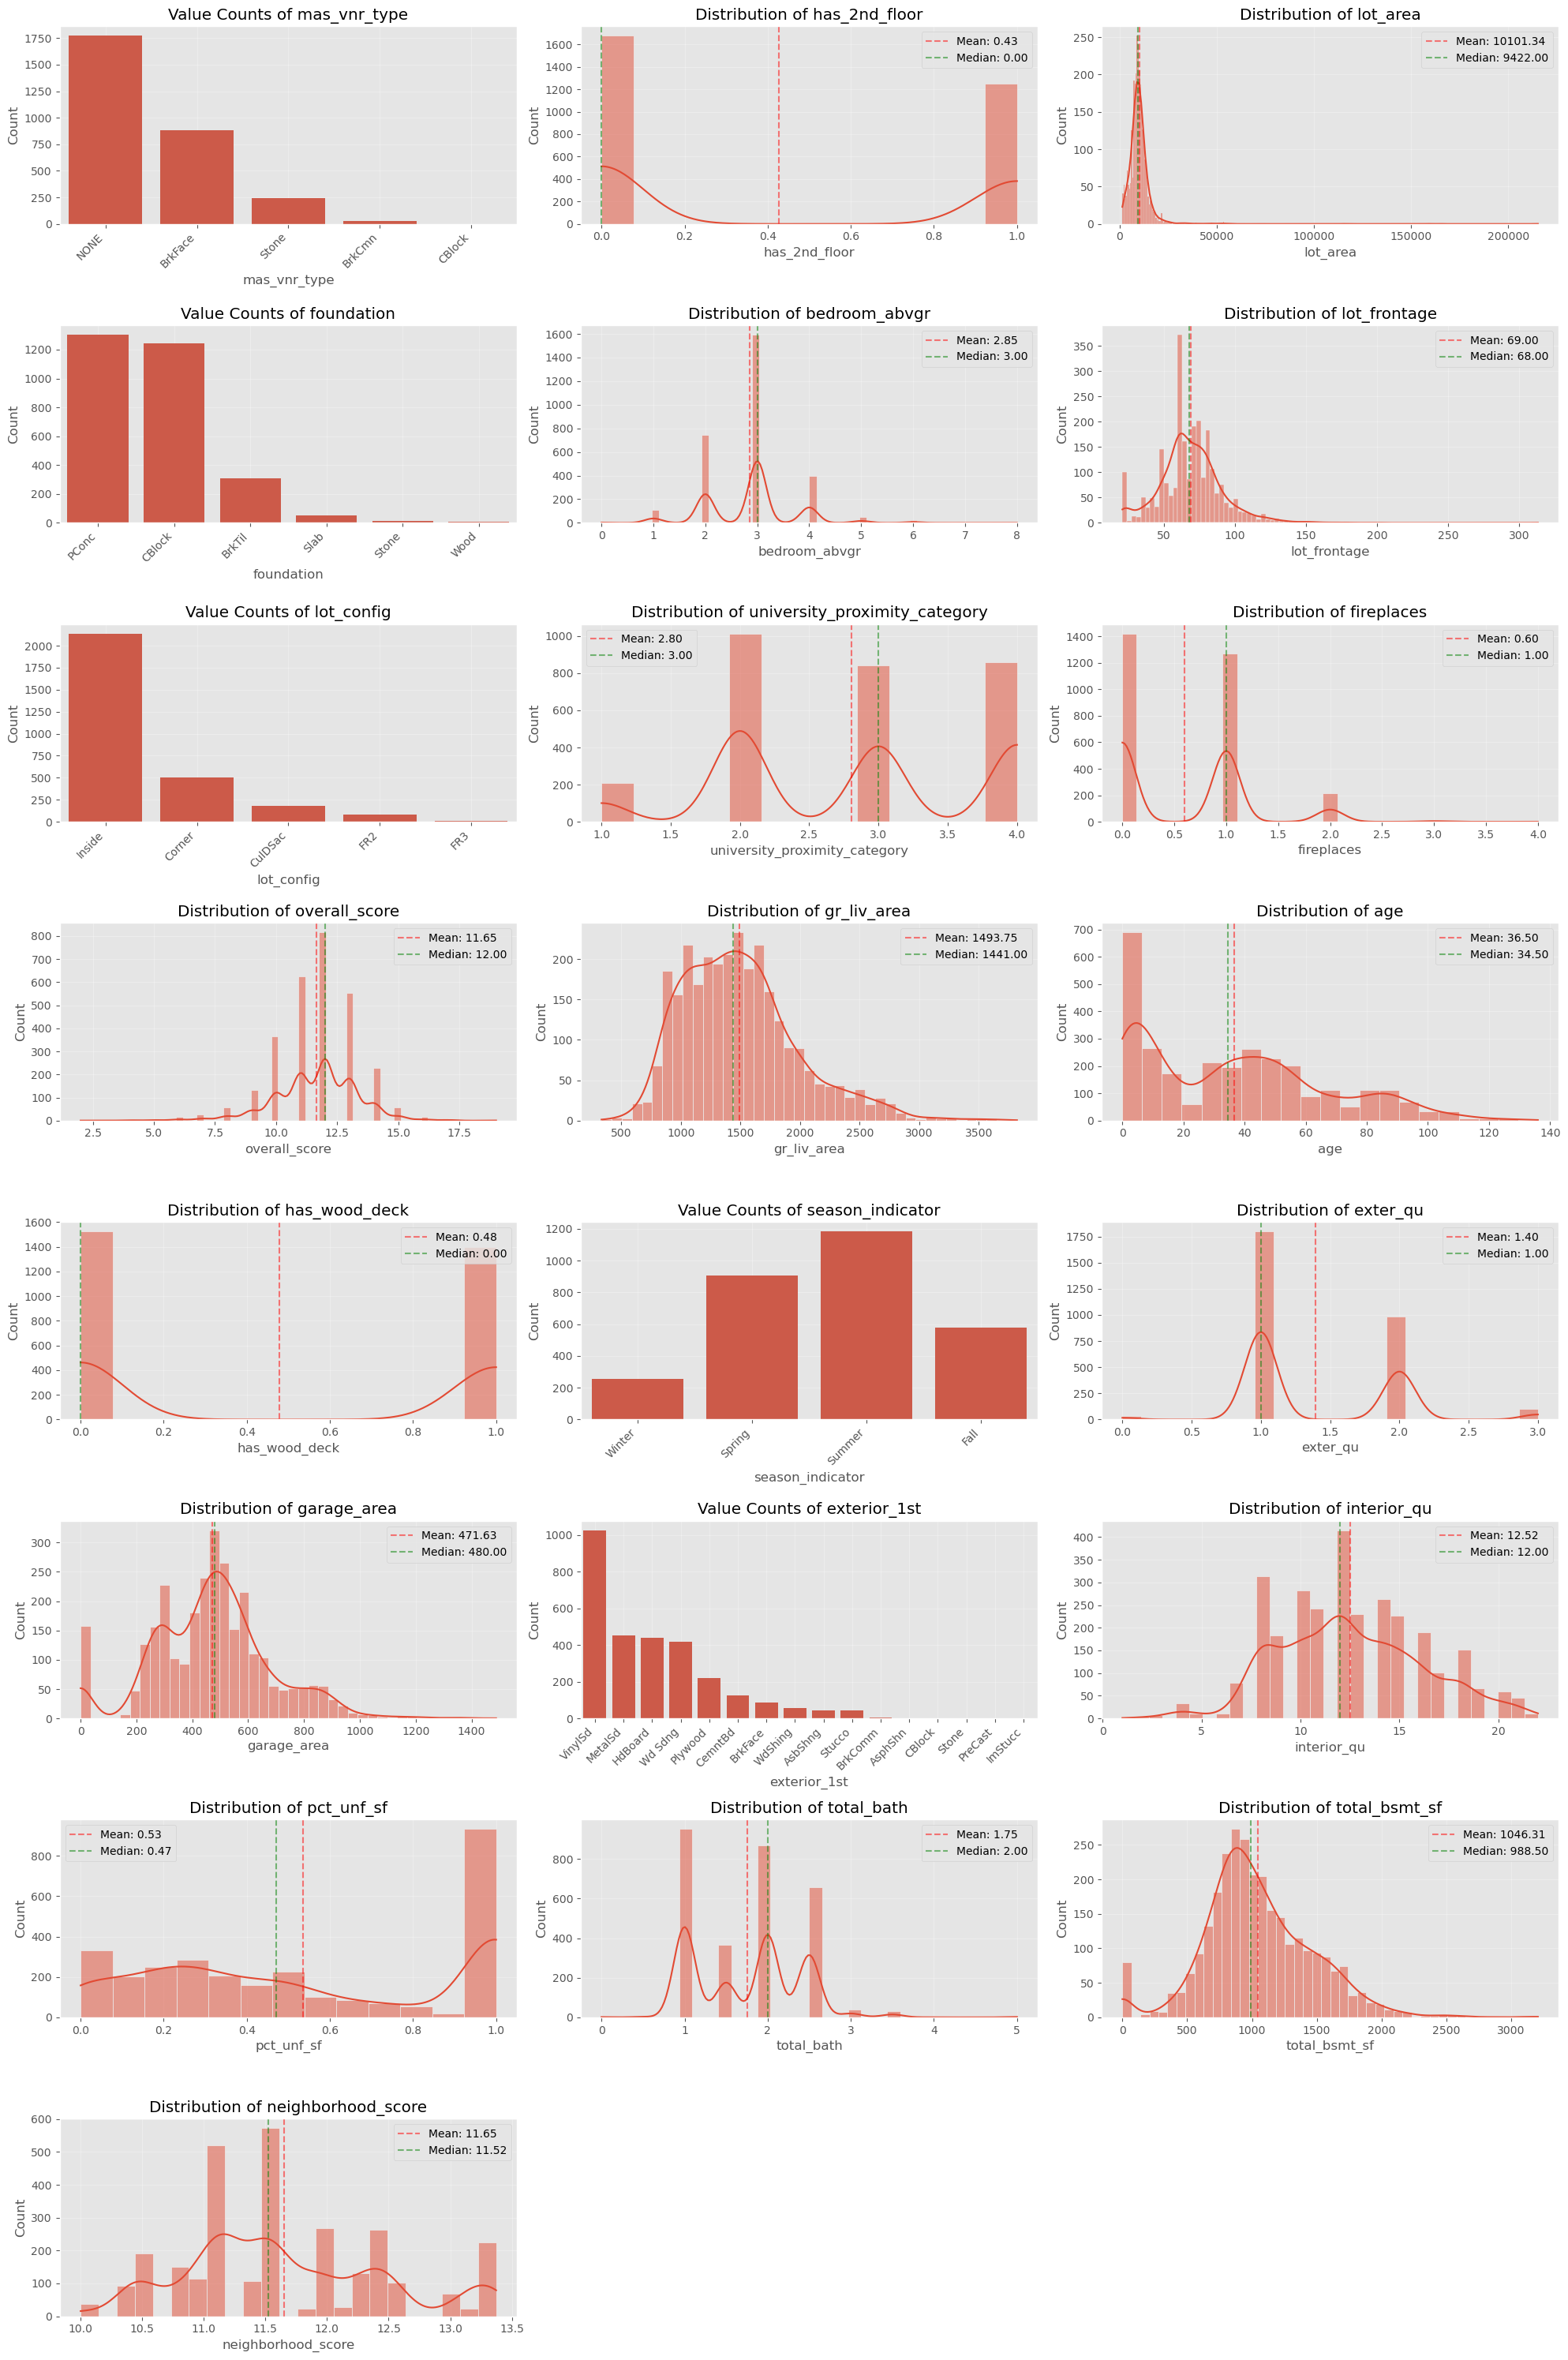

In [7]:
plot_feature_histograms(df_transformed, df_transformed.columns)

In [8]:
glm_data_dict = config['glm_data_dict']
ordinal_features = glm_data_dict['categorical']['ordinal']['columns']
nominal_features = glm_data_dict['categorical']['nominal']['columns']
numerical_features = glm_data_dict['numerical']['columns']

# 1. Grouping of infrequent ordinal categories

In [9]:
df_transformed.columns

Index(['mas_vnr_type', 'has_2nd_floor', 'lot_area', 'foundation',
       'bedroom_abvgr', 'lot_frontage', 'lot_config',
       'university_proximity_category', 'fireplaces', 'overall_score',
       'gr_liv_area', 'age', 'has_wood_deck', 'season_indicator', 'exter_qu',
       'garage_area', 'exterior_1st', 'interior_qu', 'pct_unf_sf',
       'total_bath', 'total_bsmt_sf', 'neighborhood_score'],
      dtype='object')

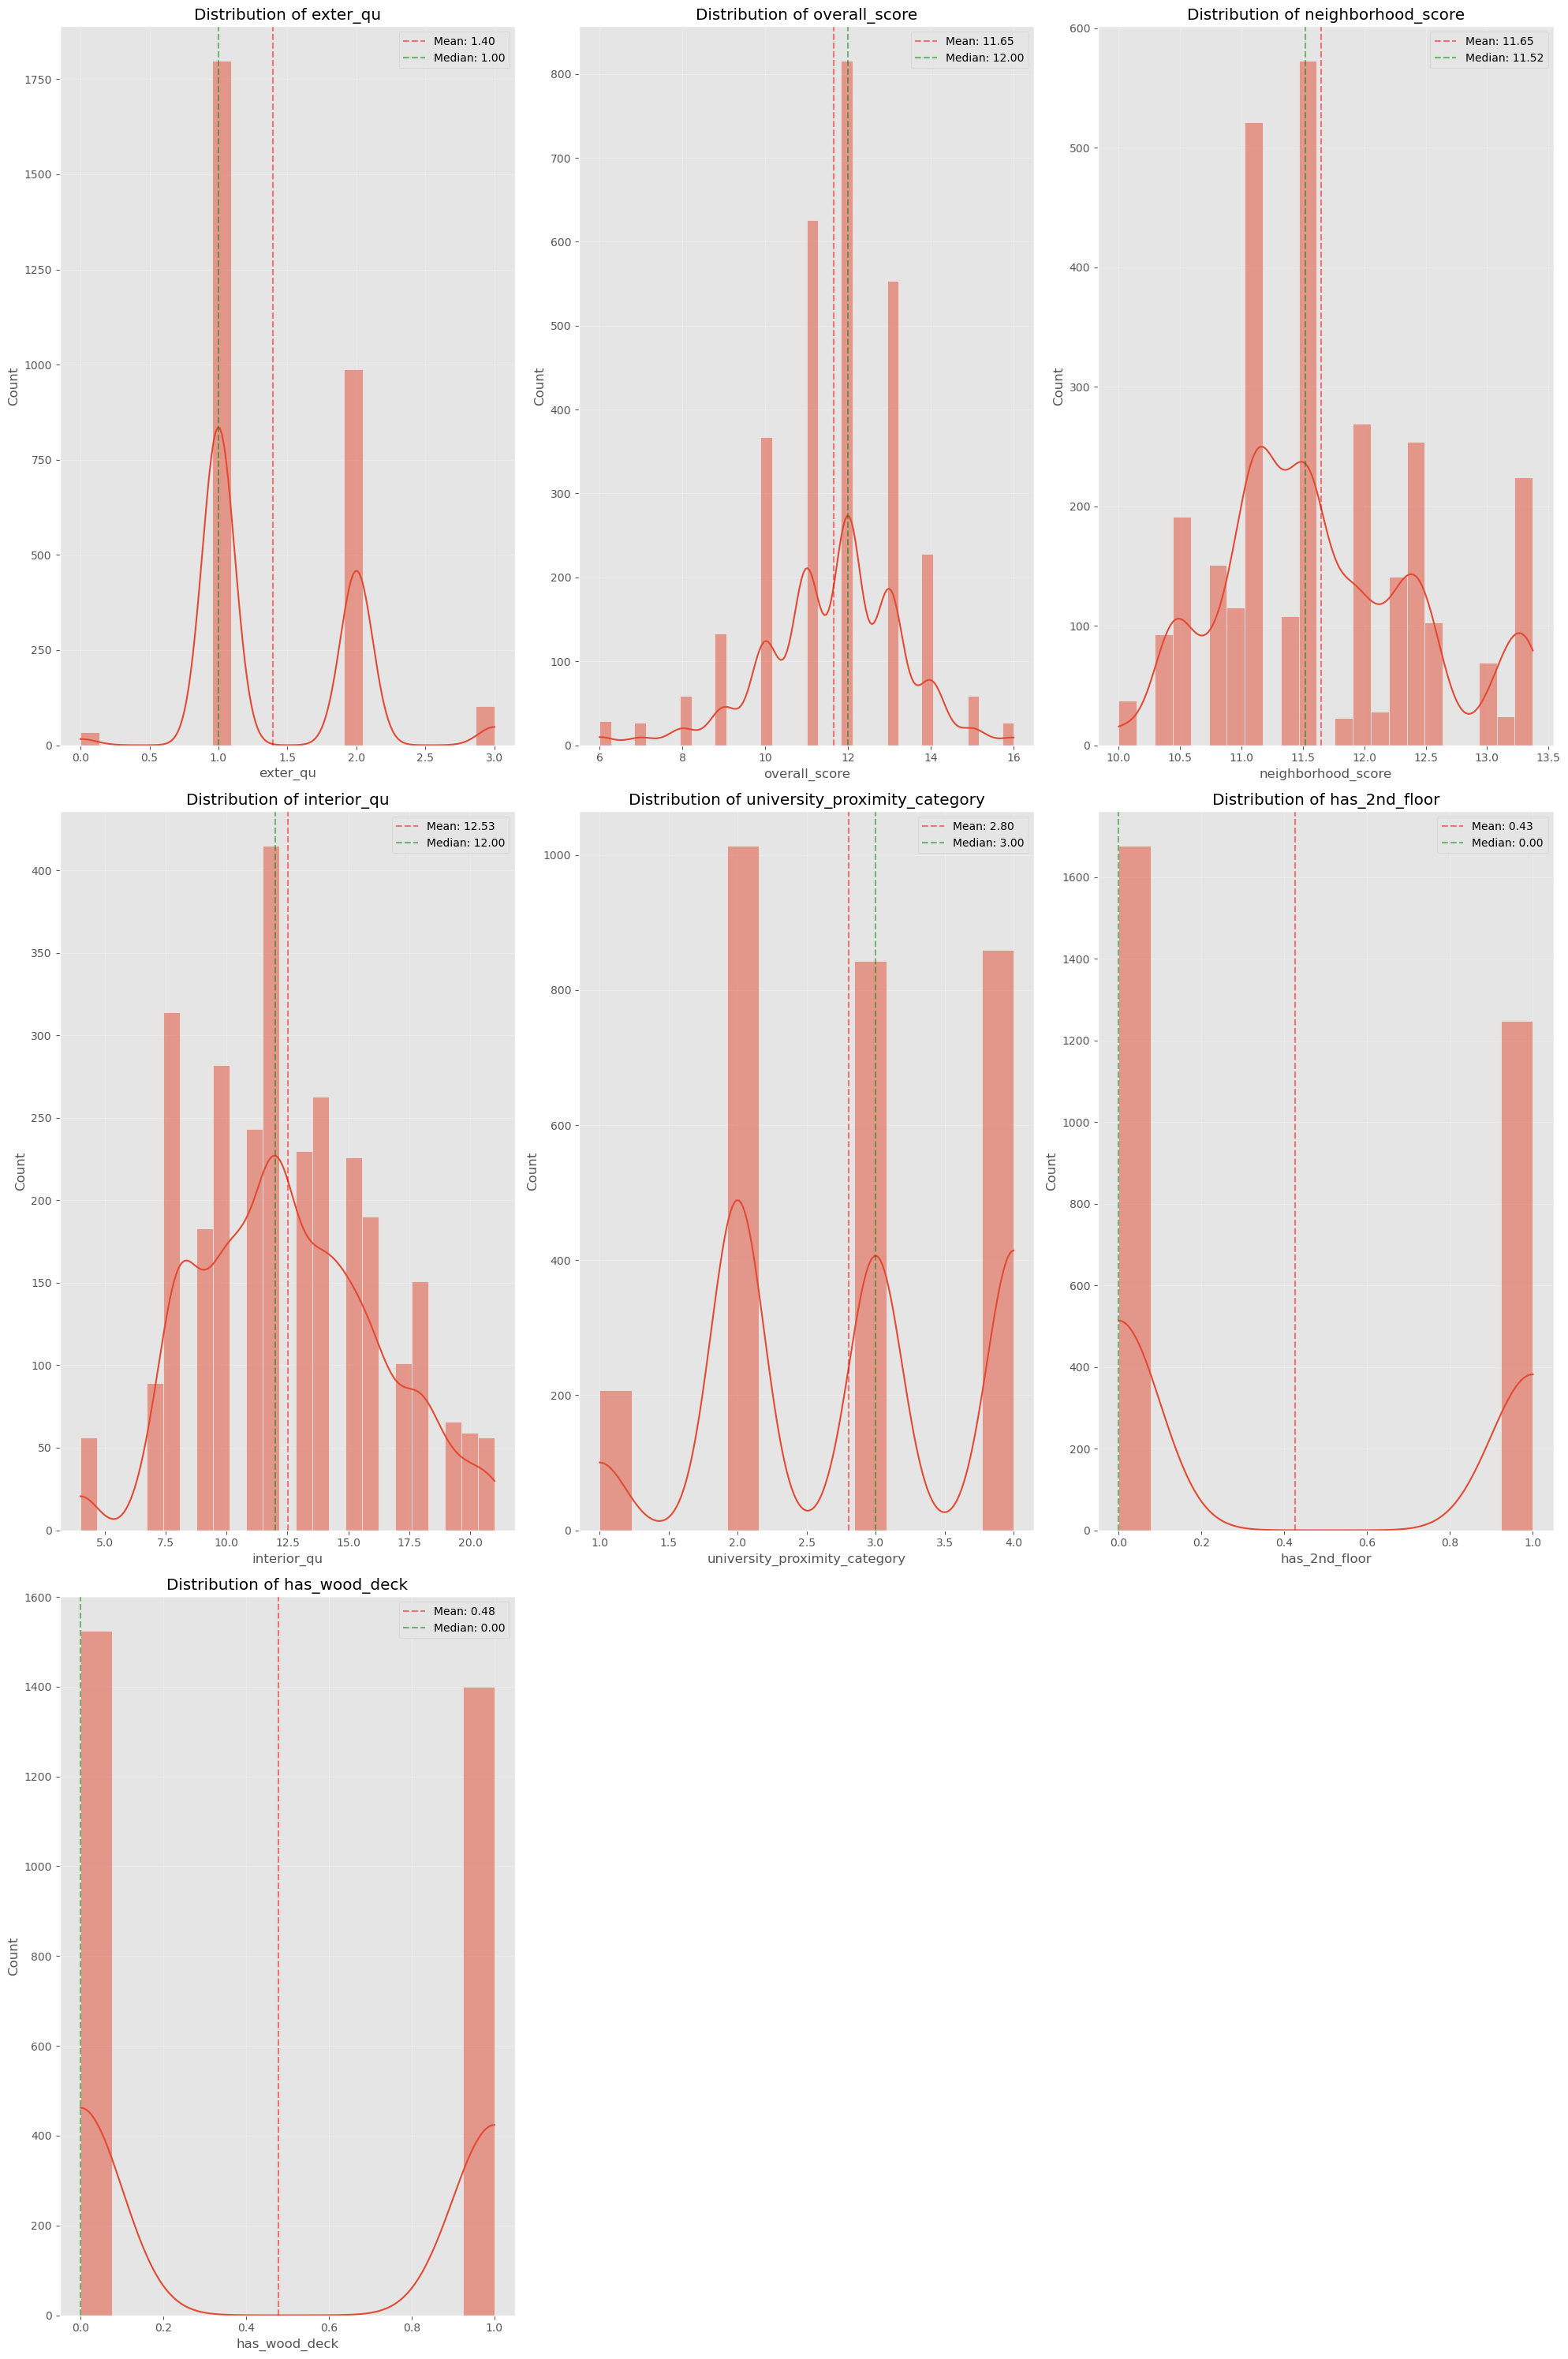

In [10]:
# Create and fit OrdinalMerger for ordinal features
min_obs = int(15)  # each category must have at least 15 observations   
ordinal_merger = OrdinalMerger(min_obs=min_obs)
df_transformed_ordinal = df_transformed[ordinal_features]
df_transformed_ordinal_merged = ordinal_merger.fit_transform(df_transformed_ordinal)

plot_feature_histograms(df_transformed_ordinal_merged)

# 2. Grouping of infrequent nominal categories

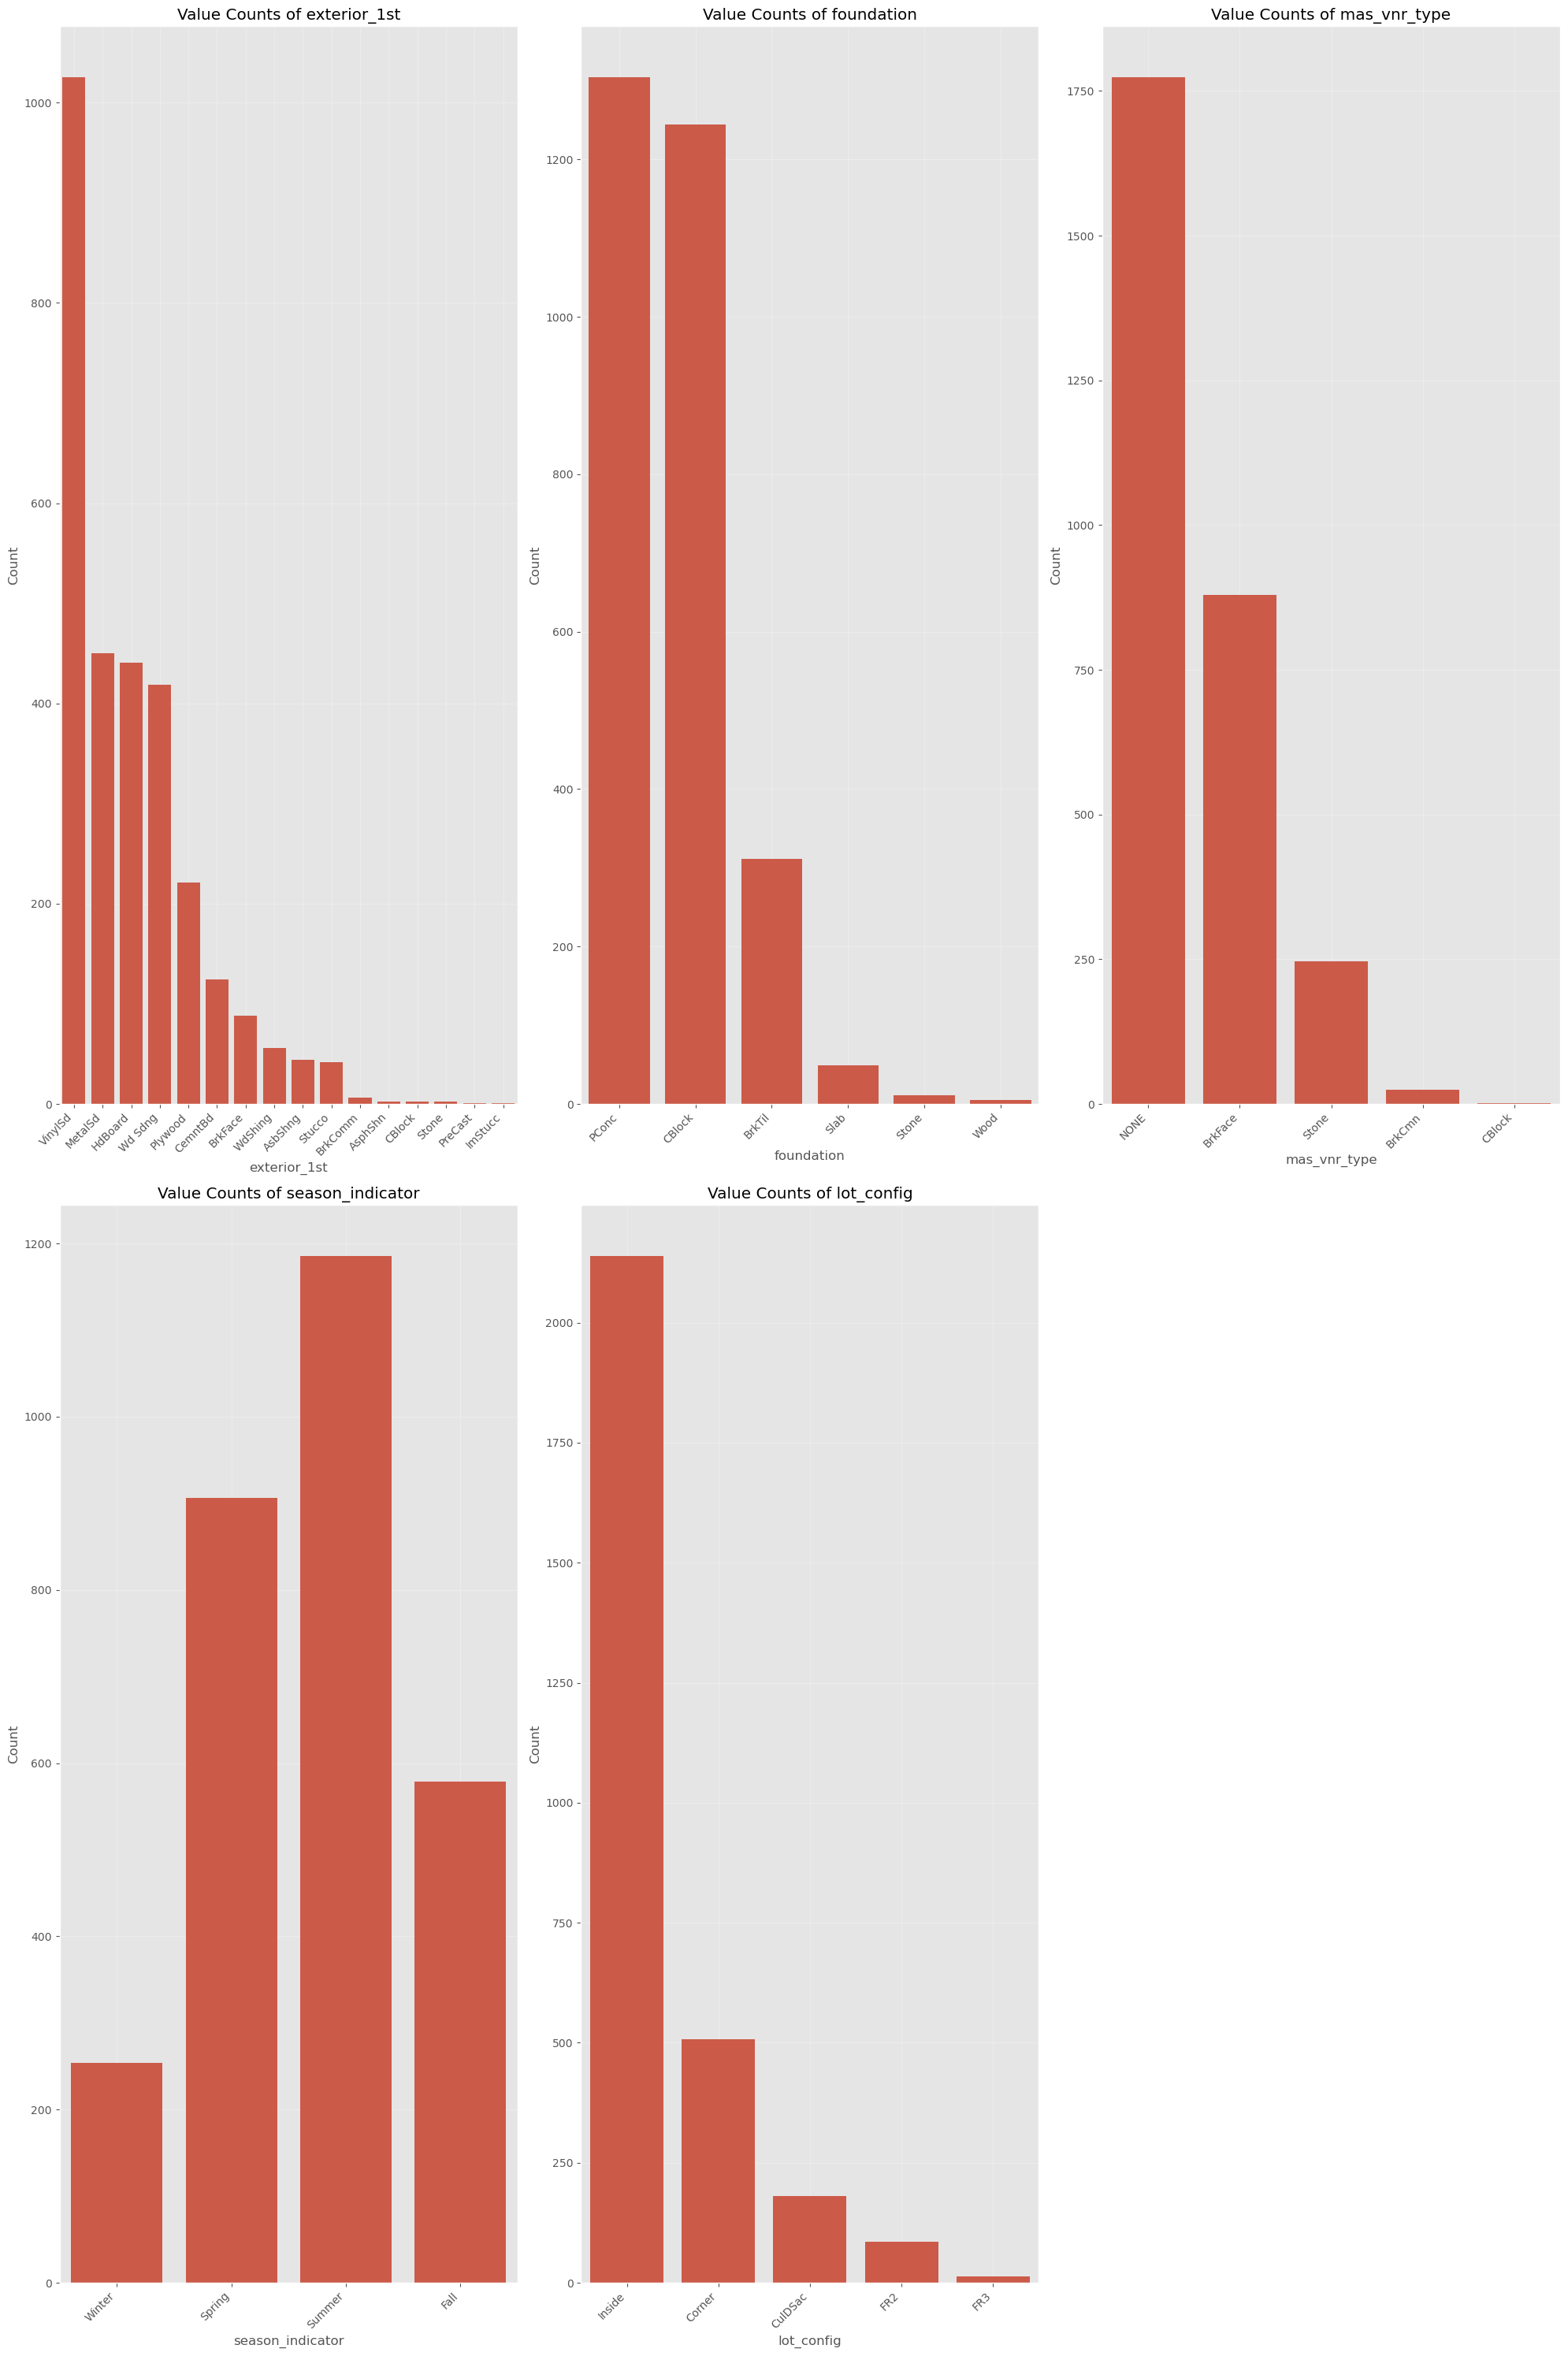

In [11]:
plot_feature_histograms(df_transformed[nominal_features])

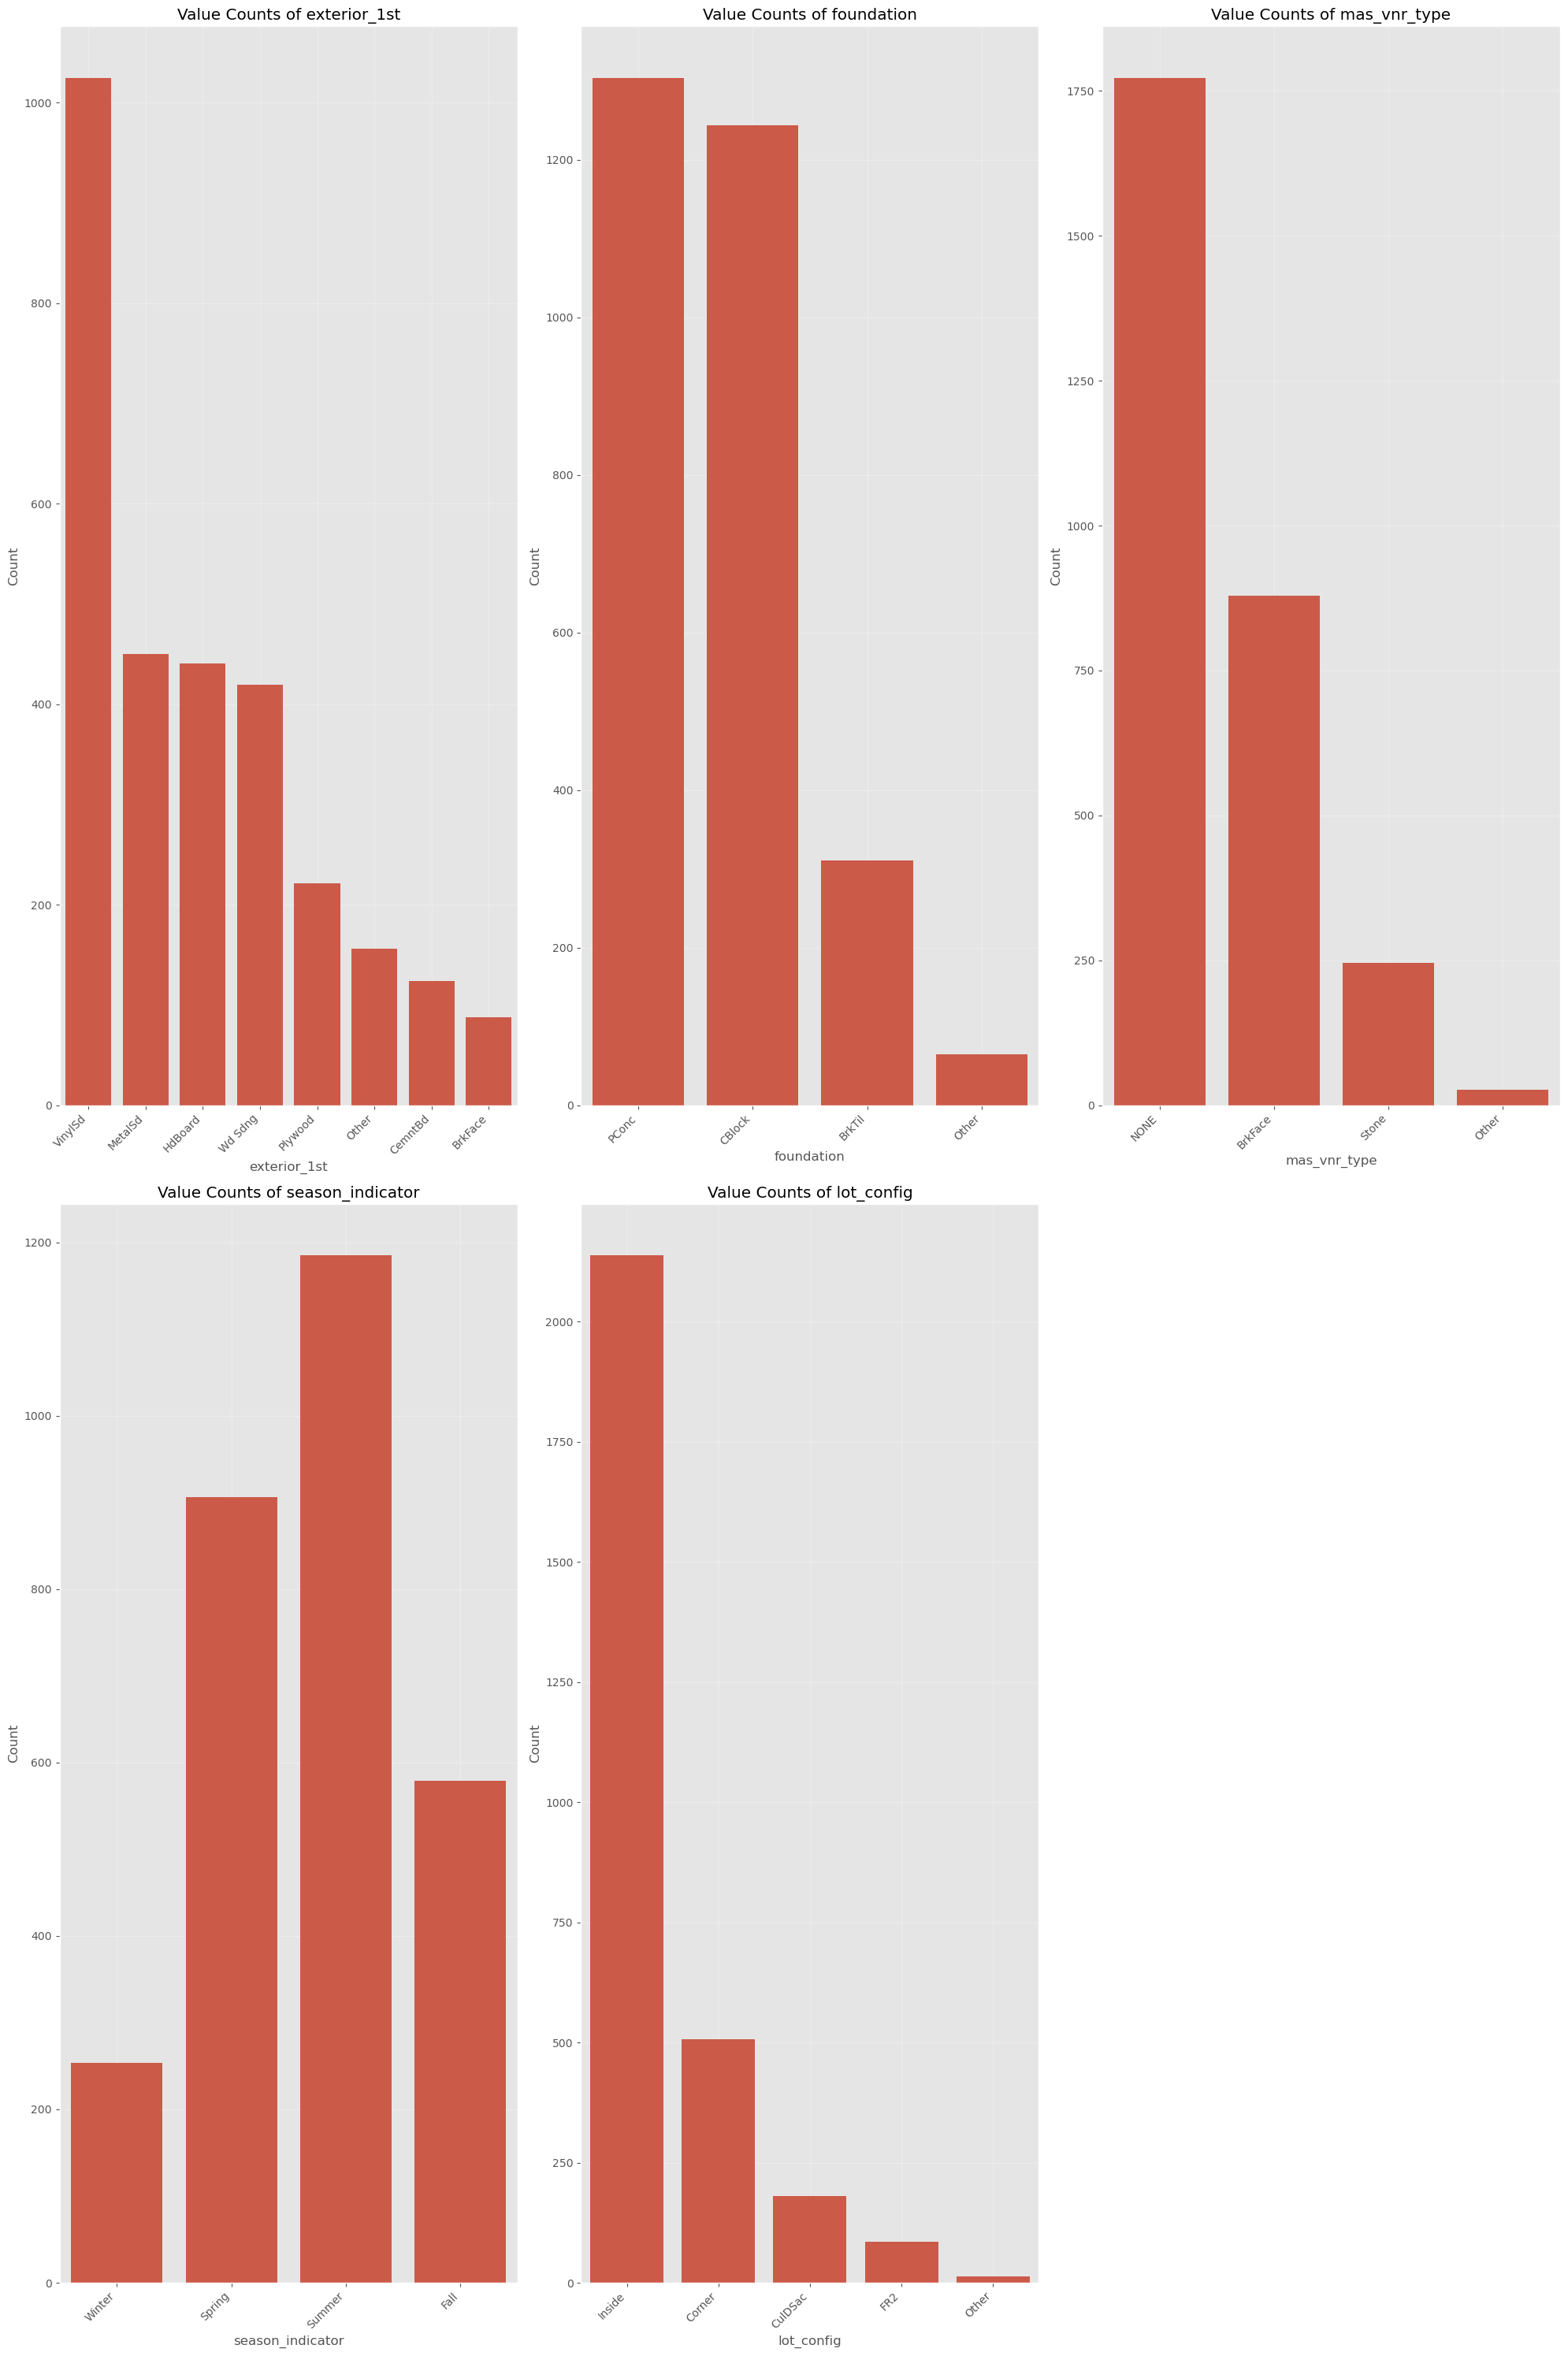

In [12]:
# Create and fit NominalGrouper for nominal features
min_obs = int(0.025 * len(df_transformed))  # 2.5% of data
nominal_grouper = NominalGrouper(min_obs=min_obs)
df_transformed_nominal = df_transformed[nominal_features]
df_transformed_nominal_transformed = nominal_grouper.fit_transform(df_transformed_nominal)

# Plot updated distributions
plot_feature_histograms(df_transformed_nominal_transformed)

# 3. Numerical Variables YeoJohnson and Scaler 

While the GLM will already potentially capture non-linear relationships, it is still a good idea to apply a YeoJohnson transformation to the numerical variables to mitigate the impact of outliers, while still best extracting the information in the data. 

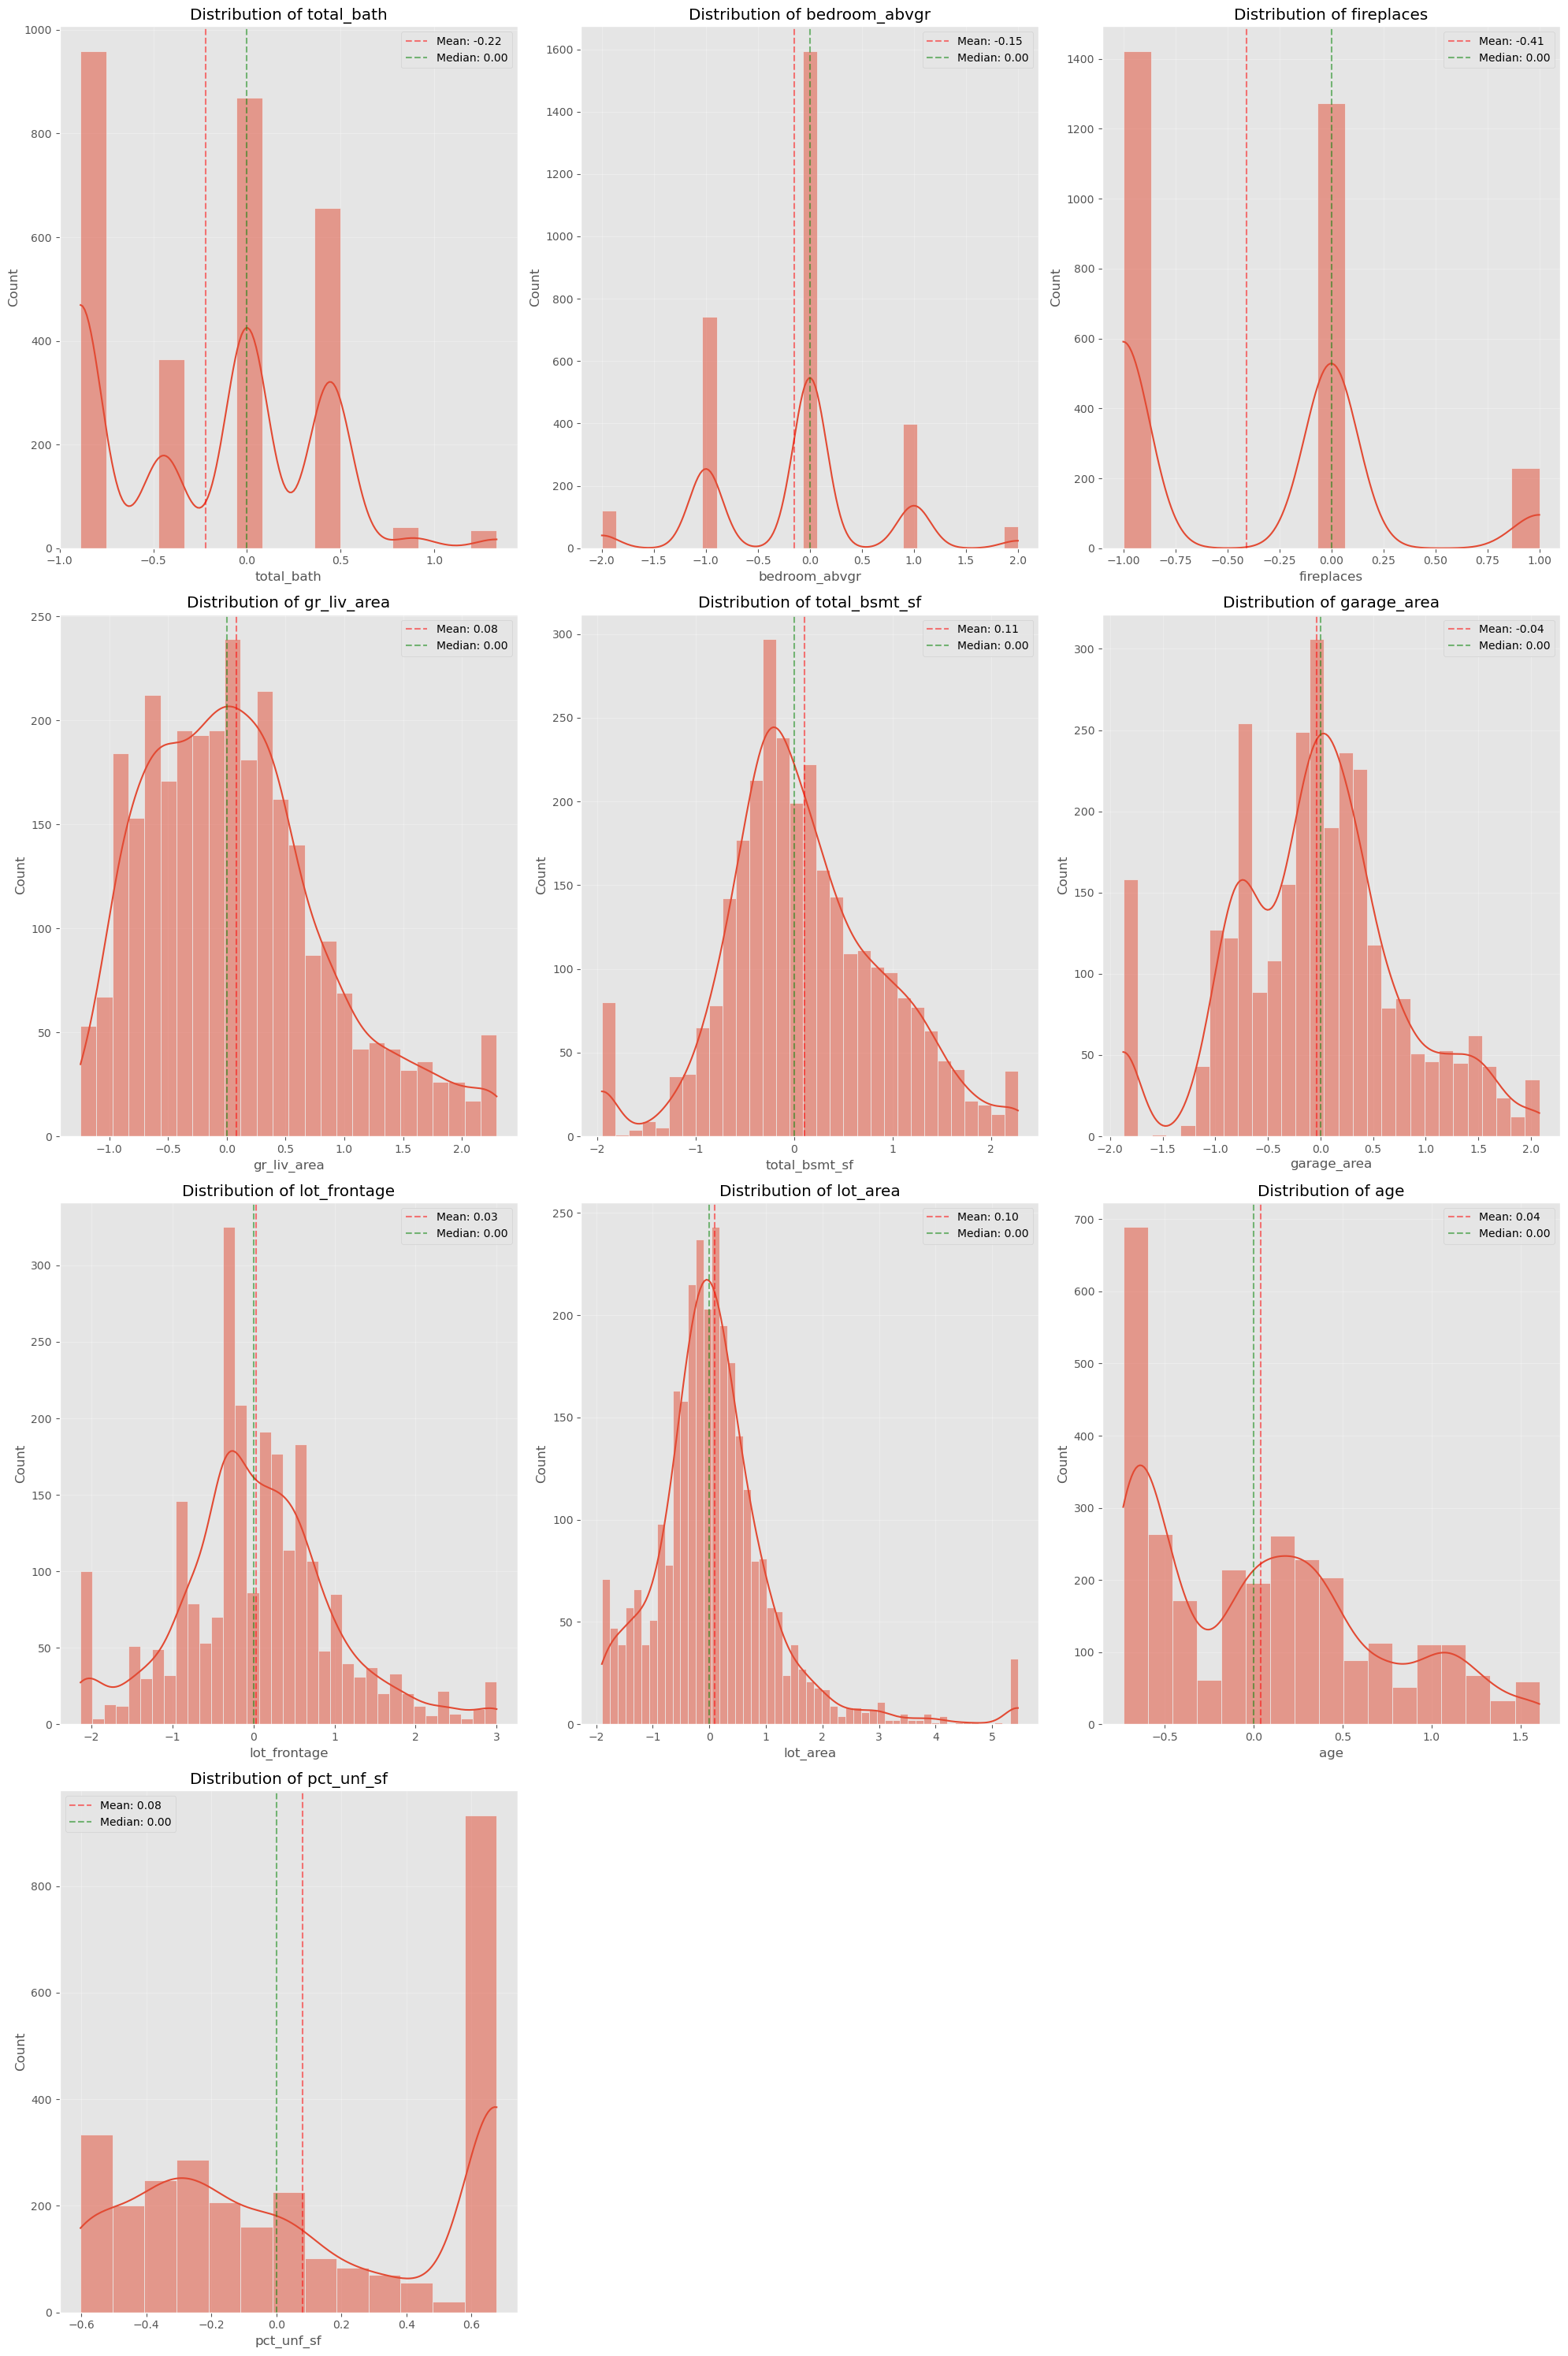

In [13]:
numerical_transformer = WinsorizedRobustScaler()
df_numerical = df_transformed[numerical_features]
df_numerical_transformed = numerical_transformer.fit_transform(df_numerical)

plot_feature_histograms(pd.DataFrame(df_numerical_transformed, columns=df_numerical.columns))
df_transformed[numerical_features] = df_numerical_transformed

# 5. Check interaction terms

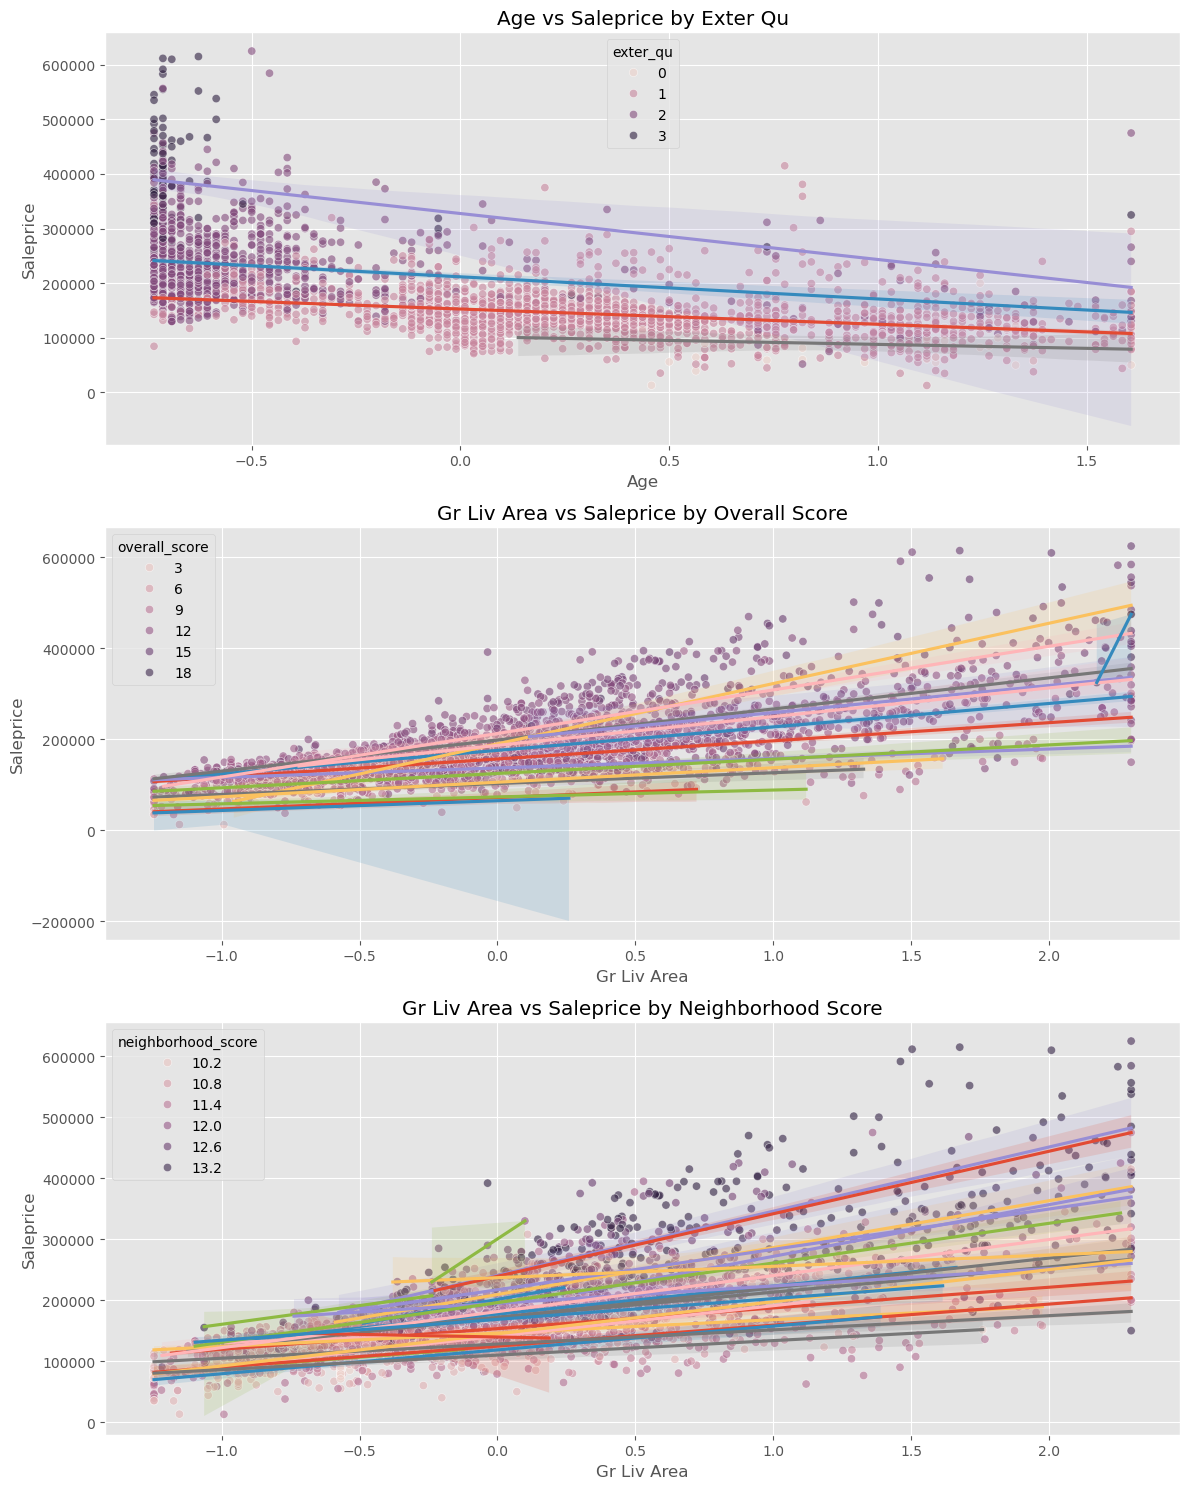

In [14]:
# Add saleprice to df_transformed for plotting
df_transformed['saleprice'] = df['saleprice']

# Define interactions to analyze
interactions_to_plot = [
    ('age', 'saleprice', 'exter_qu'),
    ('gr_liv_area', 'saleprice', 'overall_score'),
    ('gr_liv_area', 'saleprice', 'neighborhood_score')
]

# Create plots
plot_interaction_effects(df_transformed, interactions_to_plot)


1. **Age**:
   - Older homes lose value, but this effect is softened if the house has high exterior quality (`Exter Qu`).
2. **Size (Gr Liv Area)**:
   - Larger homes are worth more, but the premium depends on the house’s overall quality and the neighborhood’s desirability.
3. **Quality and Neighborhood Scores**:
   - High scores (Overall and Neighborhood) amplify the price impact of house size.